In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import GridSearchCV

## Import dataset

In [3]:
df = pd.read_csv('./SRC/boston.csv', sep=',')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Training models

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['MEDV']), df['MEDV'],test_size=0.25,shuffle=True)

### Declaring regressor

In [18]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(max_iter=2000),
    'SVR': SVR()
}

In [19]:
for i in models:
    model = models[i]
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(f'{i} MAE: {mean_absolute_error(y_test,y_predict)}')

RandomForestRegressor MAE: 2.0077322834645677
LinearRegression MAE: 3.609769359085925
MLPRegressor MAE: 3.726326248794517
SVR MAE: 5.755345895601341


## Incrinsing results

In [20]:
params = {
    'LinearRegression': {},
    'SVR': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid', ]},
    'MLPRegressor': {'hidden_layer_sizes': [(np.random(),), (500, 300), (250, 800)]},
    'RandomForestRegressor': {'n_estimators':[50,100,150,200]}
}

In [21]:
best_mae = 10
for i in models:
    model = GridSearchCV(models[i], params[i])
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_predict)
    if mae < best_mae:
        best_model = model
        best_mae = mae
    print(f'{i} {model.best_params_} {mae}')

RandomForestRegressor {'n_estimators': 50} 2.0990078740157494
LinearRegression {} 3.609769359085925
MLPRegressor {'hidden_layer_sizes': (1000,)} 3.2568044344265377
SVR {'kernel': 'linear'} 3.435303029792219


## Normalizing and standardizing the dataset

In [22]:
model = best_model.best_estimator_
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
mae_no_alter = mean_absolute_error(y_test, y_predict)
print(mae_no_alter)

1.9997480314960632


In [23]:
normalizer = Normalizer().fit(X_train)
X_train_normalized = normalizer.transform(X_train)
X_test_normalized = normalizer.transform(X_test)

In [24]:
model = best_model.best_estimator_
model.fit(X_train_normalized, y_train)
y_predict = model.predict(X_test_normalized)
mae_normalized = mean_absolute_error(y_test, y_predict)
print(mae_normalized)

2.359590551181103


In [25]:
standard = Normalizer().fit(X_train)
X_train_standardized = standard.transform(X_train)
X_test_standardized = standard.transform(X_test)


In [26]:
model = best_model.best_estimator_
model.fit(X_train_standardized, y_train)
y_predict = model.predict(X_test_standardized)
mae_standardized = mean_absolute_error(y_test, y_predict)
print(mae_standardized)

2.3092440944881885


## Plot results

In [27]:
dataframe = pd.DataFrame({
    'Data processing' : ['No alter', 'Normalized', 'Standardized'],
    'mean_absolute_erro': [mae_no_alter, mae_normalized, mae_standardized]
})

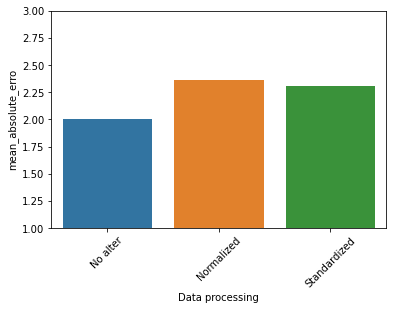

In [28]:
ax = sb.barplot(data=dataframe, x='Data processing', y='mean_absolute_erro')
ax.set(ylim=(1,3))
ax.tick_params(axis='x', rotation=45)

The difference between unchanged, normalized, and standardized datasets is very small. We can't define whether any of them are the best, although not changing the data did bring a small difference in metrics.